# Mine into subgroup 1. Extract minigroups with high concentration of PHAs

In [1]:
%matplotlib inline
import string

import math
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle, sys, os, time
import numpy as np
import pydotplus
import pandas as pd
import scipy.stats as ss
from sklearn import neighbors, svm
from sklearn.neighbors.kde import KernelDensity
from sklearn import preprocessing as pp
from sklearn import tree

import read_database as rdb
import generate_orbits as go
import learn_data as ld
import visualize_data as vd
import asterion_learn as al
from  copy import deepcopy

font = {'size': 14}
mpl.rc('font', **font)

**Prepare plot labels**

** Load generated and real NEAs from subgroup #1 **

In [2]:
dumps_gen_sg1 = ['./asteroid_data/haz_gen_sg1.p', 
                 './asteroid_data/nohaz_gen_sg1.p',
                 './asteroid_data/haz_gen_sg1_rest.p', 
                 './asteroid_data/nohaz_gen_sg1_rest.p']
            
dumps_genu = ['./asteroid_data/haz_genu_sg1.p', 
              './asteroid_data/nohaz_genu_sg1.p',
              './asteroid_data/haz_genu_sg1_rest.p', 
              './asteroid_data/nohaz_genu_sg1_rest.p']
         
dumps_real = ['./asteroid_data/haz_test.p', 
              './asteroid_data/nohaz_test.p']

haz_gen, nohaz_gen, haz_gen_rest, nohaz_gen_rest = map(rdb.loadObject, dumps_gen_sg1)
haz_genu, nohaz_genu, haz_genu_rest, nohaz_genu_rest = map(rdb.loadObject, dumps_genu)

haz_real, nohaz_real = map(rdb.loadObject, dumps_real)
# haz_gen_full = rdb.loadObject('./asteroid_data/haz_rand_2e5.p')
# nohaz_gen_full = rdb.loadObject('./asteroid_data/nohaz_rand_2e5.p')

In [3]:
haz_gen = haz_gen[haz_gen.e >= 0]
nohaz_gen = nohaz_gen[nohaz_gen.e >= 0]

haz_genu = haz_genu[haz_genu.e >= 0]
nohaz_genu = nohaz_genu[nohaz_genu.e >= 0]

** Investigate distributions of orbital parameters for the subgroup #1 **

In [4]:
# datasets_gen = [haz_gen, nohaz_gen]
# datasets_genu = [haz_genu, nohaz_genu]
# datasets_real = [haz_real, nohaz_real]

In [5]:
# vd.display_allparams([haz_gen, nohaz_gen], vd.combs, vd.colnames)

In [5]:
# reload(vd)
# vd.display_allparams(datasets_genu, vd.combs, vd.colnames)

** Draw cutting plane **

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


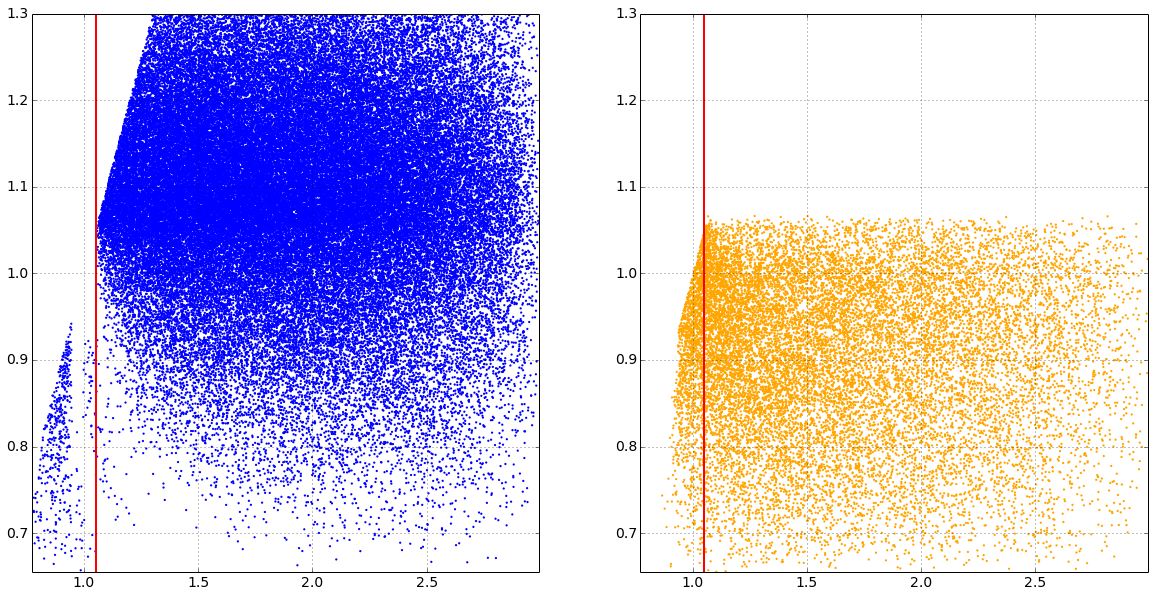

In [6]:
reload(vd)
cutcol = ['a', 'q']
a_split = 1.05
# haz_gen_cut, nohaz_gen_cut = ld.cut_2params(cutcol, [haz_gen, nohaz_gen])
haz_gen_cut, nohaz_gen_cut = ld.cut_params(haz_gen, nohaz_gen, cutcol)
p1, p2 = [[a_split, 0.0], [a_split, 360.0]]
vd.linearcut_plot(p1, p2, haz_gen_cut, nohaz_gen_cut)

In [32]:
# haz_genu_cut, nohaz_genu_cut = ld.cut_2params(cutcol, [haz_genu, nohaz_genu])
# haz_genu_cut, nohaz_genu_cut = ld.cut_params(haz_genu, nohaz_genu, cutcol)
# vd.linearcut_plot(p1, p2, haz_genu_cut, nohaz_genu_cut)

** Split asteroids of sg1 into 2 minigroups by the value of semimajor axis **

In [7]:
haz_gen_sg1a, haz_gen_sg1x = ld.split_by_colval(haz_gen, 'a', a_split)
nohaz_gen_sg1a, nohaz_gen_sg1x = ld.split_by_colval(nohaz_gen, 'a', a_split)

haz_genu_sg1a, haz_genu_sg1x = ld.split_by_colval(haz_genu, 'a', a_split)
nohaz_genu_sg1a, nohaz_genu_sg1x = ld.split_by_colval(nohaz_genu, 'a', a_split)

In [8]:
# vd.display_allparams([haz_gen_sg1a, nohaz_gen_sg1a], vd.combs, vd.colnames)

In [11]:
# vd.display_allparams([haz_gen_sg1b, nohaz_gen_sg1b], vd.combs, vd.colnames)

In [10]:
# q_split = 1.066

# haz_gen_sg1a_ql, haz_gen_sg1a_qr = ld.split_by_colval(haz_gen_sg1a, 'q', q_split)
# nohaz_gen_sg1a_ql, nohaz_gen_sg1a_qr = ld.split_by_colval(nohaz_gen_sg1a, 'q', q_split)

# haz_genu_sg1a_ql, haz_genu_sg1a_qr = ld.split_by_colval(haz_genu_sg1a, 'q', q_split)
# nohaz_genu_sg1a_ql, nohaz_genu_sg1a_qr = ld.split_by_colval(nohaz_genu_sg1a, 'q', q_split)

In [36]:
# vd.display_allparams([haz_gen_sg1a_ql, nohaz_gen_sg1a_ql], vd.combs, vd.colnames)

In [37]:
# vd.display_allparams([haz_gen_sg1a_qr, nohaz_gen_sg1a_qr], vd.combs, vd.colnames)

In [43]:
# vd.display_allparams([haz_gen_sg1b, nohaz_gen_sg1b], vd.combs, vd.colnames)

## Analyze minigroup sg1a
### Extract PHA belt from minigroup sg1a

In [12]:
# reload(ld)

** Amplify distribution by the symmetric copies of the dataset **

In [11]:
haz_gen_sg1a_symextend = ld.add_doublemirror_column(haz_gen_sg1a, 'w', 180.0)
nohaz_gen_sg1a_symextend = ld.add_doublemirror_column(nohaz_gen_sg1a, 'w', 180.0)

In [12]:
haz_genu_sg1a_symextend = ld.add_doublemirror_column(haz_genu_sg1a, 'w', 180.0)
nohaz_genu_sg1a_symextend = ld.add_doublemirror_column(nohaz_genu_sg1a, 'w', 180.0)

In [15]:
# haz_gen_sg1a_symextend = pd.concat((haz_gen_sg1a_low, haz_gen_sg1a_high, haz_gen_sg1a))
# nohaz_gen_sg1a_symextend = pd.concat((nohaz_gen_sg1a_low, nohaz_gen_sg1a_high, nohaz_gen_sg1a))

In [16]:
# print len(haz_gen_sg1a)
# print len(haz_gen_sg1a_symextend)

In [17]:
# cutcol = ['w', 'a']

In [18]:
# haz_gen_sg1a_cut, nohaz_gen_sg1a_cut = ld.cut_2params(cutcol, [haz_gen_sg1a_symextend, nohaz_gen_sg1a_symextend])
# haz_genu_sg1a_cut, nohaz_genu_sg1a_cut = ld.cut_2params(cutcol, [haz_genu_sg1a_symextend, nohaz_genu_sg1a_symextend])

In [19]:
# bounds = al.common_bounds([haz_gen_sg1a_cut, nohaz_gen_sg1a_cut, haz_genu_sg1a_cut, nohaz_genu_sg1a_cut])

In [20]:
# haz_gen_sg1a_cut, haz_gen_sg1a_sc = al.normalize_dataset(haz_gen_sg1a_cut, bounds=bounds)
# nohaz_gen_sg1a_cut, nohaz_gen_sg1a_sc = al.normalize_dataset(nohaz_gen_sg1a_cut, bounds=bounds)

# haz_genu_sg1a_cut, haz_genu_sg1a_sc = al.normalize_dataset(haz_genu_sg1a_cut, bounds=bounds)
# nohaz_genu_sg1a_cut, nohaz_genu_sg1a_sc = al.normalize_dataset(nohaz_genu_sg1a_cut, bounds=bounds)

In [21]:
# print haz_gen_sg1a_cut[:5]
# labels = [vd.colnames['w'], vd.colnames['a']]
# vd.display_param2d(cutcol, labels, [haz_gen_sg1a_symextend, nohaz_gen_sg1a_symextend])

In [22]:
# vd.display_param2d(cutcol, labels, [haz_genu_sg1a_symextend, nohaz_genu_sg1a_symextend])

In [23]:
# vd.display_allparams([haz_genu_sg1a_symextend, nohaz_genu_sg1a_symextend], vd.combs, vd.colnames)

** Add uniform and nonuniform datasets **

In [24]:
# haz_gengenu_sg1a = pd.concat((haz_gen_sg1a_symextend, haz_genu_sg1a_symextend))
# nohaz_gengenu_sg1a = pd.concat((nohaz_gen_sg1a_symextend, nohaz_genu_sg1a_symextend))

In [25]:
# vd.display_param2d(cutcol, labels, [haz_gengenu_sg1a, nohaz_gengenu_sg1a])

** Increase bottom resolution at the bottom by adding uniform strip**

In [26]:
# haz_genu_sg1a_ = haz_genu_sg1a[haz_genu_sg1a['a'] < 0.78]
# nohaz_genu_sg1a_ = nohaz_genu_sg1a[nohaz_genu_sg1a['a'] < 0.78]

# names = ['a', 'i', 'w', 'om', 'q']
# genu_mixed = pd.concat((haz_genu_sg1a_, nohaz_genu_sg1a_))

In [27]:
# unum_str = '1e4'
# unum = int(float(unum_str))
# statdists_u = [ss.uniform]*len(names)
# distlist_u = go.get_param_distributions(genu_mixed, names, statdists_u, n=30, verbose=True)
# randdata_u = go.gen_rand_orbits(None, names, distlist_u, num=unum)

In [28]:
# rdb.calc_moid(randdata_u, jobtime=True)
# haz_genu_sg1a_inc, nohaz_genu_sg1a_inc = rdb.get_hazMOID(randdata_u)

In [29]:
# haz_genu_sg1a_inc_symextend = ld.add_doublemirror_column(haz_genu_sg1a_inc, 'w', 180.0)
# nohaz_genu_sg1a_inc_symextend = ld.add_doublemirror_column(nohaz_genu_sg1a_inc, 'w', 180.0)

In [30]:
# haz_gengenu_sg1a_inc = pd.concat((haz_gengenu_sg1a, haz_genu_sg1a_inc_symextend))
# nohaz_gengenu_sg1a_inc = pd.concat((nohaz_gengenu_sg1a, nohaz_genu_sg1a_inc_symextend))

In [31]:
# vd.display_param2d(cutcol, labels, [haz_gengenu_sg1a_inc, nohaz_gengenu_sg1a_inc])

** Increase importance of 'PHA legs' by decreasing resolution of non-PHAs **

In [32]:
# halflen = int(len(nohaz_genu_sg1a_inc_symextend)*0.14)
# halh_nohaz = nohaz_genu_sg1a_inc_symextend[:halflen]
# halh_nohaz_sym = ld.add_mirror_column(halh_nohaz, 'w', 180.0)
# nohaz_gengenu_sg1a_inc = pd.concat((nohaz_gengenu_sg1a, halh_nohaz_sym))

In [33]:
# vd.display_param2d(cutcol, labels, [haz_gengenu_sg1a_inc, nohaz_gengenu_sg1a_inc])

## Extract hazardous belt with SVM

In [53]:
# reload(ld)
# cutcol = ['w', 'q', 'a']

# haz_genu_sg1a_cut, nohaz_genu_sg1a_cut = ld.cut_params(haz_genu_sg1a_symextend, nohaz_genu_sg1a_symextend, cutcol)
# bounds = al.common_bounds([haz_genu_sg1a_cut, nohaz_genu_sg1a_cut])
# haz_genu_sg1a_cut, haz_genu_sg1a_sc = al.normalize_dataset(haz_genu_sg1a_cut, bounds=bounds)
# nohaz_genu_sg1a_cut, nohaz_genu_sg1a_sc = al.normalize_dataset(nohaz_genu_sg1a_cut, bounds=bounds)

In [54]:
# scales = ld.common_scales([haz_genu_sg1a_sc, nohaz_genu_sg1a_sc])
# print scales

In [55]:
# xtrain, ytrain = ld.mix_up(haz_genu_sg1a_cut, nohaz_genu_sg1a_cut)
# # clf = neighbors.KNeighborsClassifier(n_neighbors=100)
# clf = svm.SVC(gamma=30., C=0.1)
# clf = clf.fit(xtrain, ytrain)

In [56]:
# labels = [vd.colnames['w'], vd.colnames['a']]
# vd.plot_classifier(xtrain, clf, num=200, scales=scales, cmap='ocean', labels=labels)

In [57]:
# haz_gen_sg1a_cut, nohaz_gen_sg1a_cut = ld.cut_params(haz_gen_sg1a, nohaz_gen_sg1a, cutcol)
# haz_gen_sg1a_cut, haz_gen_sg1a_sc = al.normalize_dataset(haz_gen_sg1a_cut, bounds=bounds)
# nohaz_gen_sg1a_cut, nohaz_gen_sg1a_sc = al.normalize_dataset(nohaz_gen_sg1a_cut, bounds=bounds)

In [58]:
# haz_cls = clf.predict(haz_gen_sg1a_cut)
# nohaz_cls= clf.predict(nohaz_gen_sg1a_cut)

In [59]:
# haz_extr_inds = np.where(haz_cls == 1)[0]
# nohaz_extr_inds = np.where(nohaz_cls == 1)[0]

In [60]:
# haz_left_inds = np.where(haz_cls == 0)[0]
# nohaz_left_inds = np.where(nohaz_cls == 0)[0]

In [61]:
# haz_gen_sg1a_extr = haz_gen_sg1a.iloc[haz_extr_inds]
# nohaz_gen_sg1a_extr = nohaz_gen_sg1a.iloc[nohaz_extr_inds]

In [62]:
# haz_gen_sg1a_left = haz_gen_sg1a.iloc[haz_left_inds]
# nohaz_gen_sg1a_left = nohaz_gen_sg1a.iloc[nohaz_left_inds]

In [40]:
# print len(haz_gen_sg1a_extr)
# print len(nohaz_gen_sg1a_extr)
# print 1.0 - float(len(nohaz_gen_sg1a_extr))/(len(haz_gen_sg1a_extr) + len(nohaz_gen_sg1a_extr))

In [41]:
# print float(len(haz_gen_sg1a_extr))/(len(haz_gen_sg1a_extr) + len(nohaz_gen_sg1a_extr))

In [42]:
# print len(haz_gen_sg1a_left)
# print len(nohaz_gen_sg1a_left)

In [66]:
# scale_sets = [haz_genu_sg1a_sc, nohaz_genu_sg1a_sc] 
# xsc = np.asarray([list(s[0]) for s in scale_sets]).ravel()
# ysc = np.asarray([list(s[1]) for s in scale_sets]).ravel()
# scales = [(xsc.min(), xsc.max()), (ysc.min(), ysc.max())]

In [67]:
# print haz_genu_sg1a_cut[:10]

In [68]:
# print haz_genu_sg1a_sc

In [69]:
# gen_sg1a_extr = pd.concat((haz_gen_sg1a_extr, nohaz_gen_sg1a_extr))
# cutcol = ['w', 'q', 'a']
# haz_gen_sg1a_extr_cut, nohaz_gen_sg1a_extr_cut = ld.cut_params(haz_gen_sg1a_extr, nohaz_gen_sg1a_extr, cutcol)

# bounds = al.common_bounds([haz_gen_sg1a_extr_cut, nohaz_gen_sg1a_extr_cut])

# haz_gen_sg1a_extr_cut, haz_gen_sg1a_extr_sc = al.normalize_dataset(haz_gen_sg1a_extr_cut, bounds=bounds)
# nohaz_gen_sg1a_extr_cut, nohaz_gen_sg1a_extr_sc = al.normalize_dataset(nohaz_gen_sg1a_extr_cut, bounds=bounds)

# gen_sg1a_extr_cut = np.concatenate((haz_gen_sg1a_extr_cut, nohaz_gen_sg1a_extr_cut))

In [9]:
# xs = gen_sg1a_extr_cut[:,0]
# ys = gen_sg1a_extr_cut[:,1]
# zs = gen_sg1a_extr_cut[:,2]
# print xs[:10]
# print ys[:10]
# print zs[:10]

In [10]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# %matplotlib auto
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xs, ys, zs, c='r', marker='o', lw=0, alpha=1.0, s=10)
# plt.show()

## Analyze minigroup sg1b
### Extract PHA belt from minigroup sg1b

In [17]:
# vd.display_allparams([haz_gen_sg1b, nohaz_gen_sg1b], vd.combs, vd.colnames)

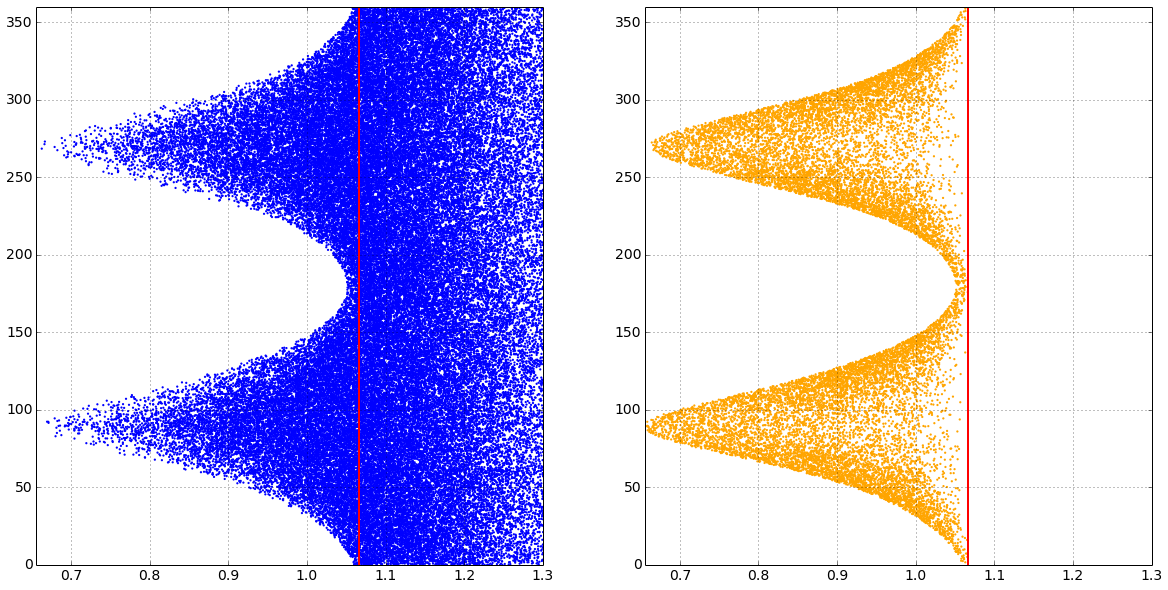

In [9]:
reload(ld)
q_split = 1.066
cutcol = ['q', 'w']
haz_gen_cut, nohaz_gen_cut = ld.cut_params(haz_gen_sg1x, nohaz_gen_sg1x, cutcol)
# haz_gen_cut, nohaz_gen_cut = ld.cut_params(haz_gen, nohaz_gen, cutcol)
# haz_gen_cut, nohaz_gen_cut = ld.cut_2params(cutcol, [haz_gen_sg1b, nohaz_gen_sg1b])
p1, p2 = [[q_split, 0.0], [q_split, 360.0]]
vd.linearcut_plot(p1, p2, haz_gen_cut, nohaz_gen_cut)

In [10]:
haz_gen_sg1b, haz_gen_sg1z = ld.split_by_colval(haz_gen_sg1x, 'q', q_split)
nohaz_gen_sg1b, nohaz_gen_sg1z = ld.split_by_colval(nohaz_gen_sg1x, 'q', q_split)

haz_genu_sg1b, haz_genu_sg1z = ld.split_by_colval(haz_genu_sg1x, 'q', q_split)
nohaz_genu_sg1b, nohaz_genu_sg1z = ld.split_by_colval(nohaz_genu_sg1x, 'q', q_split)

In [11]:
# vd.display_allparams([haz_gen_sg1b, nohaz_gen_sg1b], vd.combs, vd.colnames)

In [12]:
haz_gen_sg1x_se = ld.add_doublemirror_column(haz_gen_sg1x, 'w', 180.0)
nohaz_gen_sg1x_se = ld.add_doublemirror_column(nohaz_gen_sg1x, 'w', 180.0)

In [13]:
haz_gen_sg1b_se = ld.add_doublemirror_column(haz_gen_sg1b, 'w', 180.0)
nohaz_gen_sg1b_se = ld.add_doublemirror_column(nohaz_gen_sg1b, 'w', 180.0)

In [14]:
haz_genu_sg1b_se = ld.add_doublemirror_column(haz_genu_sg1b, 'w', 180.0)
nohaz_genu_sg1b_se = ld.add_doublemirror_column(nohaz_genu_sg1b, 'w', 180.0)

## Slice a fat piece

In [25]:
reload(ld)
cutcol = ['w', 'q', 'i', 'a']

haz_gen_sg1b_cut, nohaz_gen_sg1b_cut = ld.cut_params(haz_gen_sg1b_se, nohaz_gen_sg1b_se, cutcol)
bounds = al.common_bounds([haz_gen_sg1b_cut, nohaz_gen_sg1b_cut])
haz_gen_sg1b_cut, haz_gen_sg1b_sc = al.normalize_dataset(haz_gen_sg1b_cut, bounds=bounds)
nohaz_gen_sg1b_cut, nohaz_gen_sg1b_sc = al.normalize_dataset(nohaz_gen_sg1b_cut, bounds=bounds)

In [26]:
xtrain, ytrain = ld.mix_up(haz_gen_sg1b_cut, nohaz_gen_sg1b_cut)
clf = neighbors.KNeighborsClassifier(n_neighbors=800)
# clf = svm.SVC(gamma=30., C=1.0)
clf = clf.fit(xtrain, ytrain)

In [27]:
# vd.plot_classifier(xtrain, clf, num=300, cmap='winter')

In [28]:
haz_gen_sg1b_cut, nohaz_gen_sg1b_cut = ld.cut_params(haz_gen_sg1b, nohaz_gen_sg1b, cutcol)
haz_gen_sg1b_cut, haz_gen_sg1b_sc = al.normalize_dataset(haz_gen_sg1b_cut, bounds=bounds)
nohaz_gen_sg1b_cut, nohaz_gen_sg1b_sc = al.normalize_dataset(nohaz_gen_sg1b_cut, bounds=bounds)

In [29]:
haz_cls = clf.predict(haz_gen_sg1b_cut)
nohaz_cls= clf.predict(nohaz_gen_sg1b_cut)

In [30]:
haz_extr_inds = np.where(haz_cls == 1)[0]
nohaz_extr_inds = np.where(nohaz_cls == 1)[0]

In [31]:
haz_left_inds = np.where(haz_cls == 0)[0]
nohaz_left_inds = np.where(nohaz_cls == 0)[0]

In [32]:
haz_gen_sg1b_extr = haz_gen_sg1b.iloc[haz_extr_inds]
nohaz_gen_sg1b_extr = nohaz_gen_sg1b.iloc[nohaz_extr_inds]

In [33]:
haz_gen_sg1b_left = haz_gen_sg1b.iloc[haz_left_inds]
nohaz_gen_sg1b_left = nohaz_gen_sg1b.iloc[nohaz_left_inds]

In [34]:
print len(haz_gen_sg1b_extr)
print len(nohaz_gen_sg1b_extr)
print 1.0 - float(len(nohaz_gen_sg1b_extr))/(len(haz_gen_sg1b_extr) + len(nohaz_gen_sg1b_extr))
print len(haz_gen_sg1b_left)
print len(nohaz_gen_sg1b_left)

10782
1499
0.877941535706
5551
30129


In [35]:
# df = clf.decision_function(haz_gen_sg1c_cut)
# print df

In [36]:
# df.shape
# print min(np.abs(df))
# print max(np.abs(df))

In [82]:
# vd.display_param2d(cutcol, labels, [haz_gen_sg1c_extr, nohaz_gen_sg1c_extr])

In [251]:
# vd.display_allparams([haz_gen_sg1c_extr, nohaz_gen_sg1c_extr], vd.combs, vd.colnames)

In [83]:
# vd.display_allparams([haz_gen_sg1c_left, nohaz_gen_sg1c_left], vd.combs, vd.colnames)

** Leftovers **

In [84]:
# cutcol = ['w', 'q', 'i']
# haz_gen_sg1c_left_cut, nohaz_gen_sg1c_left_cut = ld.cut_params(haz_gen_sg1c_left, nohaz_gen_sg1c_left, cutcol)
# bounds = al.common_bounds([haz_gen_sg1c_left_cut, nohaz_gen_sg1c_left_cut])
# haz_gen_sg1c_left_cut, haz_gen_sg1c_left_sc = al.normalize_dataset(haz_gen_sg1c_left_cut, bounds=bounds)
# nohaz_gen_sg1c_left_cut, nohaz_gen_sg1c_left_sc = al.normalize_dataset(nohaz_gen_sg1c_left_cut, bounds=bounds)

In [85]:
# xtrain, ytrain = ld.mix_up(haz_gen_sg1c_left_cut, nohaz_gen_sg1c_left_cut)
# clf = neighbors.KNeighborsClassifier(n_neighbors=100)
# clf = svm.SVC(gamma=80., C=1.0)
# clf = clf.fit(xtrain, ytrain)

In [86]:
# haz_cls = clf.predict(haz_gen_sg1c_left_cut)
# nohaz_cls = clf.predict(nohaz_gen_sg1c_left_cut)

In [87]:
# haz_extr_inds = np.where(haz_cls == 1)[0]
# nohaz_extr_inds = np.where(nohaz_cls == 1)[0]

In [88]:
# haz_left_inds = np.where(haz_cls == 0)[0]
# nohaz_left_inds = np.where(nohaz_cls == 0)[0]

In [89]:
# haz_gen_sg1c_leftE = haz_gen_sg1c_left.iloc[haz_extr_inds]
# nohaz_gen_sg1c_leftE = nohaz_gen_sg1c_left.iloc[nohaz_extr_inds]

In [90]:
# haz_gen_sg1c_leftL = haz_gen_sg1c_left.iloc[haz_left_inds]
# nohaz_gen_sg1c_leftL = nohaz_gen_sg1c_left.iloc[nohaz_left_inds]

In [91]:
# print 1.0 - float(len(nohaz_gen_sg1c_leftE))/(len(haz_gen_sg1c_leftE) + len(nohaz_gen_sg1c_leftE))

In [92]:
# print len(haz_gen_sg1c_leftE)
# print len(nohaz_gen_sg1c_leftE)

In [93]:
# print len(haz_gen_sg1c_leftL)
# print len(nohaz_gen_sg1c_leftL)

In [94]:
# print 1.0 - float(len(nohaz_gen_sg1c_leftL))/(len(haz_gen_sg1c_leftL) + len(nohaz_gen_sg1c_leftL))

## Apply simple cut by tree by semi-major axis and inclination

In [268]:
# # haz_train_cut, nohaz_train_cut = ld.prepare_data(cutcol=['a', 'i'], datasets=[haz_gen, nohaz_gen])
# # xtrain, ytrain, xtest, ytest = ld.get_learndata([haz_train_cut, nohaz_train_cut, haz_test_cut, nohaz_test_cut])

# # reload(ld)
# cutcol = ['a', 'i']
# xtrain, ytrain = ld.learning_sets(haz_gen, nohaz_gen, cutcol)
# clf = tree.DecisionTreeClassifier(max_depth=2) 
# clf = clf.fit(xtrain, ytrain)

In [267]:
# # reload(vd)
# # haz_gen_cut, nohaz_gen_cut = ld.prepare_data(cutcol=cutcol, datasets=[haz_gen, nohaz_gen])
# haz_gen_cut, nohaz_gen_cut = ld.cut_2params(cutcol, [haz_gen, nohaz_gen])
# labels = [vd.colnames['a'], vd.colnames['i']]
# # vd.plot_classifier(xtrain, clf,  cmap='ocean_r', labels=labels, rescale=False)
# vd.plot_classifier(xtrain, clf, cmap='ocean_r', haz=haz_gen_cut, nohaz=nohaz_gen_cut, 
#                    labels=labels, rescale=False, figsize=(8,8))

In [266]:
# al.fit_predict(xtrain, ytrain, xtrain, ytrain, clf)

In [265]:
# haz_predicted = clf.predict(haz_gen_cut)
# nohaz_predicted = clf.predict(nohaz_gen_cut)

# haz_num = len(np.where(haz_predicted == 1)[0])
# nohaz_num = len(np.where(nohaz_predicted == 1)[0])
# purity = float(haz_num)/(haz_num + nohaz_num)
# print purity

## Split subgroup into 2 minigroups by the density of nonhazardous asteroids

In [9]:
# cutcol = ['a', 'i']
# labels = [vd.colnames['a'], vd.colnames['i']]
# vd.display_param2d(cutcol, labels, [haz_gen, nohaz_gen]) #invertaxes=[0,1]

In [15]:
# print len(haz_gen_sg1c_left)
# print len(nohaz_gen_sg1c_left)
# print len(haz_gen_sg1c_left)*100/1e5
# print float(len(nohaz_gen_sg1c_left))/(len(nohaz_gen_sg1c_left)+len(haz_gen_sg1c_left))

** Cut w and q **

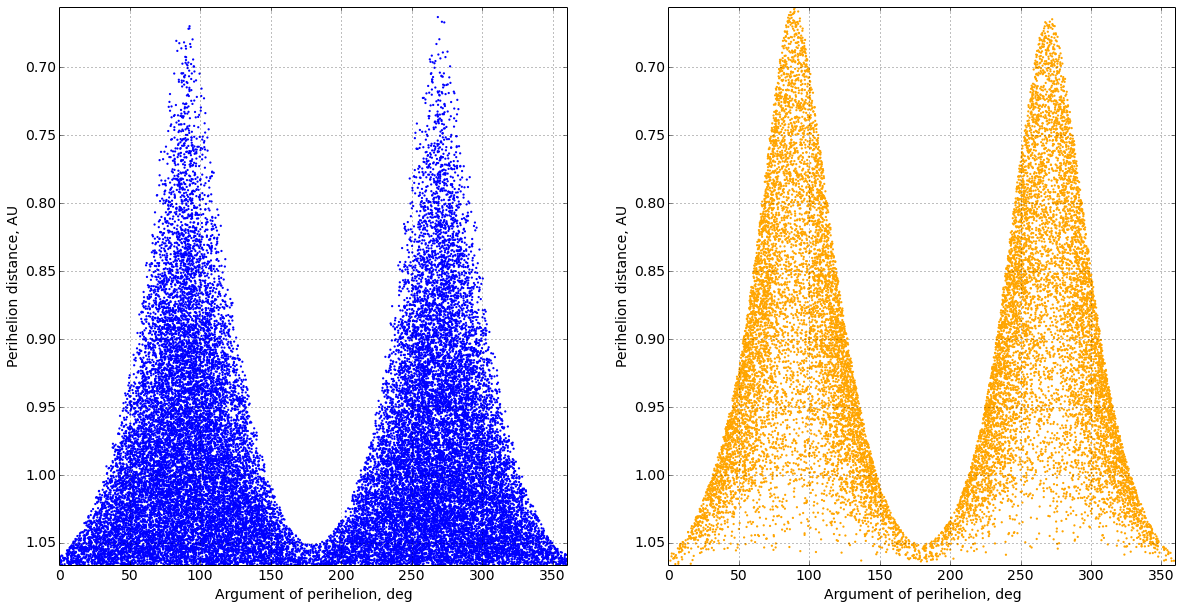

In [16]:
cutcol = ['w', 'q']
labels = [vd.colnames['w'], vd.colnames['q']]
vd.display_param2d(cutcol, labels, [haz_gen_sg1b, nohaz_gen_sg1b], invertaxes=[0,1])

** Normalize datasets **

In [20]:
haz_gen_sg1x_se_cut, nohaz_gen_sg1x_se_cut = ld.cut_params(haz_gen_sg1x_se, nohaz_gen_sg1x_se, cutcol)
# haz_gen_sg1b_se_cut, nohaz_gen_sg1b_se_cut = ld.cut_2params(cutcol, [haz_gen_sg1b_se, nohaz_gen_sg1b_se])
bounds = al.common_bounds([haz_gen_sg1x_se_cut, nohaz_gen_sg1x_se_cut])
haz_gen_sg1x_se_cut, haz_gen_sg1x_se_sc = al.normalize_dataset(haz_gen_sg1x_se_cut, bounds=bounds)
nohaz_gen_sg1x_se_cut, nohaz_gen_sg1x_se_sc = al.normalize_dataset(nohaz_gen_sg1x_se_cut, bounds=bounds)

In [21]:
haz_gen_sg1b_se_cut, nohaz_gen_sg1b_se_cut = ld.cut_params(haz_gen_sg1b_se, nohaz_gen_sg1b_se, cutcol)
# haz_gen_sg1b_se_cut, nohaz_gen_sg1b_se_cut = ld.cut_2params(cutcol, [haz_gen_sg1b_se, nohaz_gen_sg1b_se])
# bounds = al.common_bounds([haz_gen_sg1b_se_cut, nohaz_gen_sg1b_se_cut])
haz_gen_sg1b_se_cut, haz_gen_sg1b_se_sc = al.normalize_dataset(haz_gen_sg1b_se_cut, bounds=bounds)
nohaz_gen_sg1b_se_cut, nohaz_gen_sg1b_se_sc = al.normalize_dataset(nohaz_gen_sg1b_se_cut, bounds=bounds)

In [22]:
haz_gen_sg1b_cut, nohaz_gen_sg1b_cut = ld.cut_params(haz_gen_sg1b, nohaz_gen_sg1b, cutcol)
# haz_gen_sg1b_se_cut, nohaz_gen_sg1b_se_cut = ld.cut_2params(cutcol, [haz_gen_sg1b_se, nohaz_gen_sg1b_se])
# bounds = al.common_bounds([haz_gen_sg1b_cut, nohaz_gen_sg1b_cut])
haz_gen_sg1b_cut, haz_gen_sg1b_sc = al.normalize_dataset(haz_gen_sg1b_cut, bounds=bounds)
nohaz_gen_sg1b_cut, nohaz_gen_sg1b_sc = al.normalize_dataset(nohaz_gen_sg1b_cut, bounds=bounds)

In [49]:
# # haz_gen_cut, nohaz_gen_cut = ld.cut_2params(cutcol, [haz_gen, nohaz_gen])
# # haz_gen_cutn, haz_sc = al.normalize_dataset(haz_gen_cut)
# # nohaz_gen_cutn, nohaz_sc = al.normalize_dataset(nohaz_gen_cut)


# # haz_gen_sg1c_cut, nohaz_gen_sg1c_cut = ld.cut_params(haz_gen_sg1c_left, nohaz_gen_sg1c_left, cutcol)
# haz_gen_sg1c_cut, nohaz_gen_sg1c_cut = ld.cut_2params(cutcol, [haz_gen_sg1c_left, nohaz_gen_sg1c_left])
# # haz_gen_sg1c_cut, nohaz_gen_sg1c_cut = ld.cut_params(haz_gen_sg1c, nohaz_gen_sg1c, cutcol)
# # bounds = al.common_bounds([haz_gen_sg1c_cut, nohaz_gen_sg1c_cut])
# haz_gen_sg1c_cut, haz_gen_sg1c_sc = al.normalize_dataset(haz_gen_sg1c_cut, bounds=bounds)
# nohaz_gen_sg1c_cut, nohaz_gen_sg1c_sc = al.normalize_dataset(nohaz_gen_sg1c_cut, bounds=bounds)

** Find common scale **

In [51]:
# xsc = np.asarray([list(ss[0]) for ss in [haz_sc, nohaz_sc]]).ravel()
# ysc = np.asarray([list(ss[1]) for ss in [haz_sc, nohaz_sc]]).ravel()
# scales = [(xsc.min(), xsc.max()), (ysc.min(), ysc.max())]

# scales = ld.common_scales([haz_gen_sg1b_sc, nohaz_gen_sg1b_sc])
# scales = ld.common_scales([haz_gen_sg1c_sc, nohaz_gen_sg1c_sc])

** Extend nonhazardous dataset with narrow bands on the top to get better KDE fit **

In [215]:
# def gen_strips(amounts, bounds):
#     strips = []
#     for a, b in zip(amounts, bounds):
#         h, v = a
#         right, left, bottom, top = b
        
#         hrand = np.array([np.random.uniform(low=left, high=right, size=v) for i in range(h)])
#         vrand = np.array([np.random.uniform(low=bottom, high=top, size=h) for i in range(v)]).T
        
#         hrand_ = hrand.ravel().T
#         vrand_ = vrand.ravel().T
        
#         rand_strip = np.concatenate((hrand_, vrand_)).reshape(2, len(vrand_)).T
#         strips.append(rand_strip)
#     return strips

In [216]:
# am1 = [250, 7]
# sb1 = [-0.02, 0.42, 0.99, 1.04]
# sb2 = [0.58,  1.02, 0.99, 1.04]
# sb3 = [0.04,  0.36, 0.99, 1.04]
# sb4 = [0.64,  0.96, 0.99, 1.04]

# am2 = [250, 7]
# sb5 = [-0.04, 0.44, 1.04, 1.09]
# sb6 = [0.56,  1.04, 1.04, 1.09]
# sb7 = [0.02,  0.38, 1.04, 1.09]
# sb8 = [0.62,  0.98, 1.04, 1.09]

# am3 = [200, 10]
# sb9 = [-0.02, 0.42, 1.09, 1.2]
# sb10 = [0.58, 1.02, 1.09, 1.2]
# sb11 = [0.04, 0.36, 1.09, 1.2]
# sb12 = [0.64, 0.96, 1.09, 1.2]

# # strips = gen_strips([am12, am12], [sb1, sb2])
# # strips = gen_strips([am34, am34], [sb3, sb4])
# # strips = gen_strips([am12, am12, am34, am34], [sb1, sb2, sb3, sb4])
# # strips = gen_strips([am56, am56], [sb5, sb6])
# # strips = gen_strips([am78, am78], [sb7, sb8])
# strips = gen_strips([am1, am1, am1, am1, am2, am2, am2, am2, am3, am3, am3, am3], 
#                     [sb1, sb2, sb3, sb4, sb5, sb6, sb7, sb8, sb9, sb10, sb11, sb12])

In [217]:
# extended = [nohaz_gen_cutn] + strips
# nohaz_gen_cutn_ = np.concatenate(tuple(extended))

In [218]:
# labels_norm = [vd.colnames_norm['w'], vd.colnames_norm['q']]
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111)
# ax.scatter(nohaz_gen_cutn_[..., 0], nohaz_gen_cutn_[..., 1], s=1, lw=0)
# ax.set_xlabel(labels_norm[0])
# ax.set_ylabel(labels_norm[1])
# ax.grid(True)
# ax.invert_yaxis()
# plt.show()

** Fit Kernel Density model based on density distribution for nonhazardous dataset **

In [65]:
kde = KernelDensity(kernel='linear', bandwidth=0.1).fit(nohaz_gen_sg1x_se_cut)
# kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(nohaz_gen_cutn_)
# reload(al)
levels, xyz = al.normgrid_kde(kde, levnum=7) # scales=scales

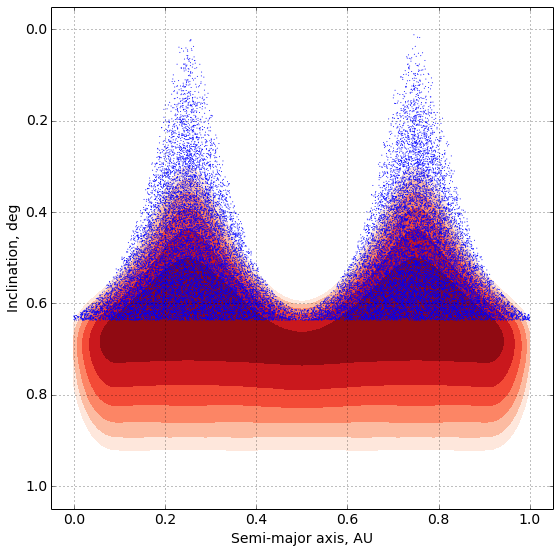

In [66]:
x, y, z = xyz
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.contourf(x, y, z, levels=levels, cmap=plt.cm.Reds)
ax.scatter(nohaz_gen_sg1b_cut[..., 0], nohaz_gen_sg1b_cut[..., 1], s=1, lw=0)
ax.grid(True)
# ax.set_xlim(scales[0])
# ax.set_ylim(scales[1])
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.invert_yaxis()
plt.show()
# reload(vd)
# vd.plot_kde(kde, levnum=4, figsize=(10,10), scales=scales)

In [67]:
# Zhaz = kde.score_samples(haz_gen_sg1c_cut)
# Znohaz = kde.score_samples(nohaz_gen_sg1c_cut)

Zhaz = kde.score_samples(haz_gen_sg1b_cut)
Znohaz = kde.score_samples(nohaz_gen_sg1b_cut)

** Split datasets by density clusters **

In [68]:
mingi_haz = al.split_minigroups(Zhaz, levels)
mingi_nohaz = al.split_minigroups(Znohaz, levels)

In [69]:
# print mingi_haz[-4]

In [70]:
haz_mg11_inds = mingi_haz[-1]
nohaz_mg11_inds = mingi_nohaz[-1]
haz_gen_mg11 = haz_gen_sg1b.iloc[haz_mg11_inds]
nohaz_gen_mg11 = nohaz_gen_sg1b.iloc[nohaz_mg11_inds]

haz_mg12_inds = mingi_haz[-2]
nohaz_mg12_inds = mingi_nohaz[-2]
haz_gen_mg12 = haz_gen_sg1b.iloc[haz_mg12_inds]
nohaz_gen_mg12 = nohaz_gen_sg1b.iloc[nohaz_mg12_inds]

haz_mg13_inds = mingi_haz[-3]
nohaz_mg13_inds = mingi_nohaz[-3]
haz_gen_mg13 = haz_gen_sg1b.iloc[haz_mg13_inds]
nohaz_gen_mg13 = nohaz_gen_sg1b.iloc[nohaz_mg13_inds]

# haz_mg14_inds = mingi_haz[-4]
# nohaz_mg14_inds = mingi_nohaz[-4]
# haz_gen_mg14 = haz_gen_sg1c.iloc[haz_mg14_inds]
# nohaz_gen_mg14 = nohaz_gen_sg1c.iloc[nohaz_mg14_inds]

haz_rest_inds = list(set(range(len(haz_gen_sg1b))) - set(haz_mg11_inds + haz_mg12_inds + haz_mg13_inds))
nohaz_rest_inds = list(set(range(len(nohaz_gen_sg1b))) - set(nohaz_mg11_inds + nohaz_mg12_inds + nohaz_mg13_inds))

haz_gen_mg14 = haz_gen_sg1b.iloc[haz_rest_inds]
nohaz_gen_mg14 = nohaz_gen_sg1b.iloc[nohaz_rest_inds]

In [71]:
def split_minigroup(haz_mg, nohaz_mg, clf, cutcol):
    
    haz_cut, nohaz_cut = ld.cut_2params(cutcol, [haz_mg, nohaz_mg])
    
    haz_predicted = clf.predict(haz_cut)
    nohaz_predicted = clf.predict(nohaz_cut)
    
    haz_extr_inds = np.where(haz_predicted == 1)[0]
    haz_rest_inds = np.where(haz_predicted == 0)[0]

    nohaz_extr_inds = np.where(nohaz_predicted == 1)[0]
    nohaz_rest_inds = np.where(nohaz_predicted == 0)[0]
    
    haz_num = len(haz_extr_inds)
    nohaz_num = len(nohaz_extr_inds)
    purity = float(haz_num)/(haz_num + nohaz_num)
    print "purity:", purity
    
    haz_mg_extr = haz_mg.iloc[haz_extr_inds]
    nohaz_mg_extr = nohaz_mg.iloc[nohaz_extr_inds]
    
    haz_mg_rest = haz_mg.iloc[haz_rest_inds]
    nohaz_mg_rest = nohaz_mg.iloc[nohaz_rest_inds]
    
    return haz_mg_extr, nohaz_mg_extr, haz_mg_rest, nohaz_mg_rest
  

## Mine minigroup 1.1

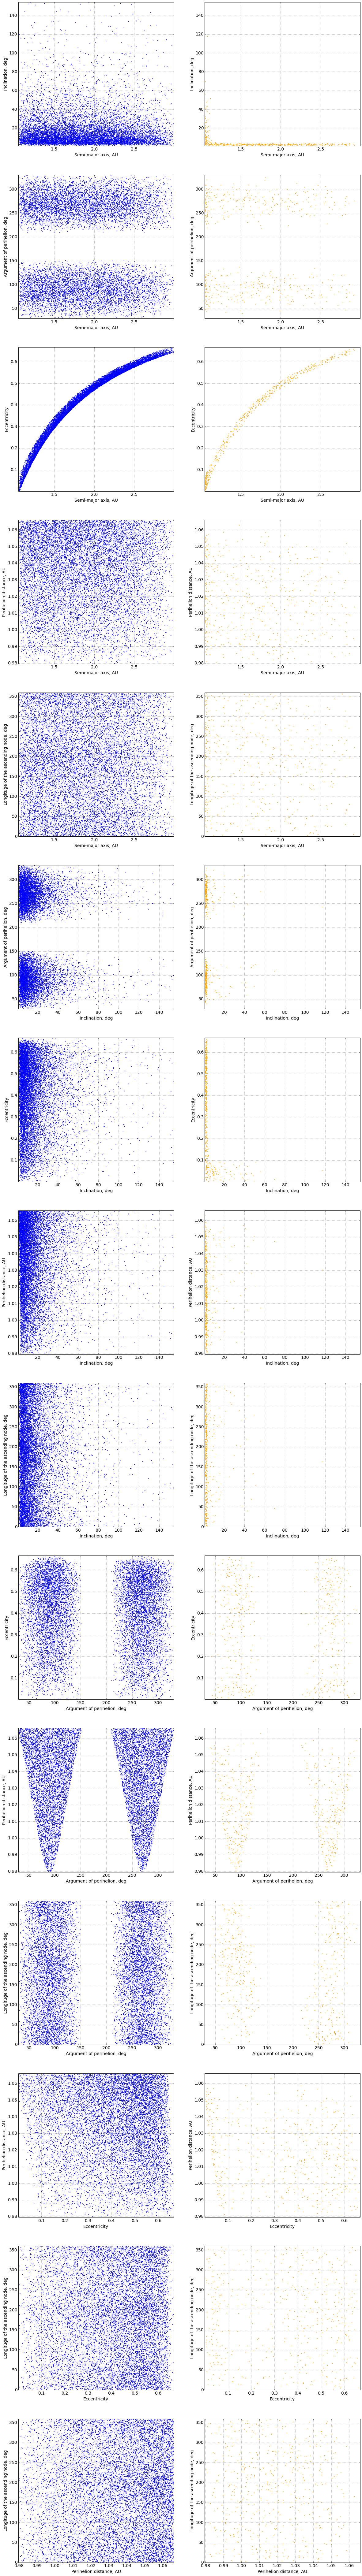

In [72]:
vd.display_allparams([haz_gen_mg11, nohaz_gen_mg11], vd.combs, vd.colnames)

In [127]:
# haz_gen_mg11, nohaz_gen_mg11 = haz_gen_sg1c_extr, nohaz_gen_sg1c_extr
# haz_gen_mg11, nohaz_gen_mg11 = haz_gen_sg1c_left, nohaz_gen_sg1c_left

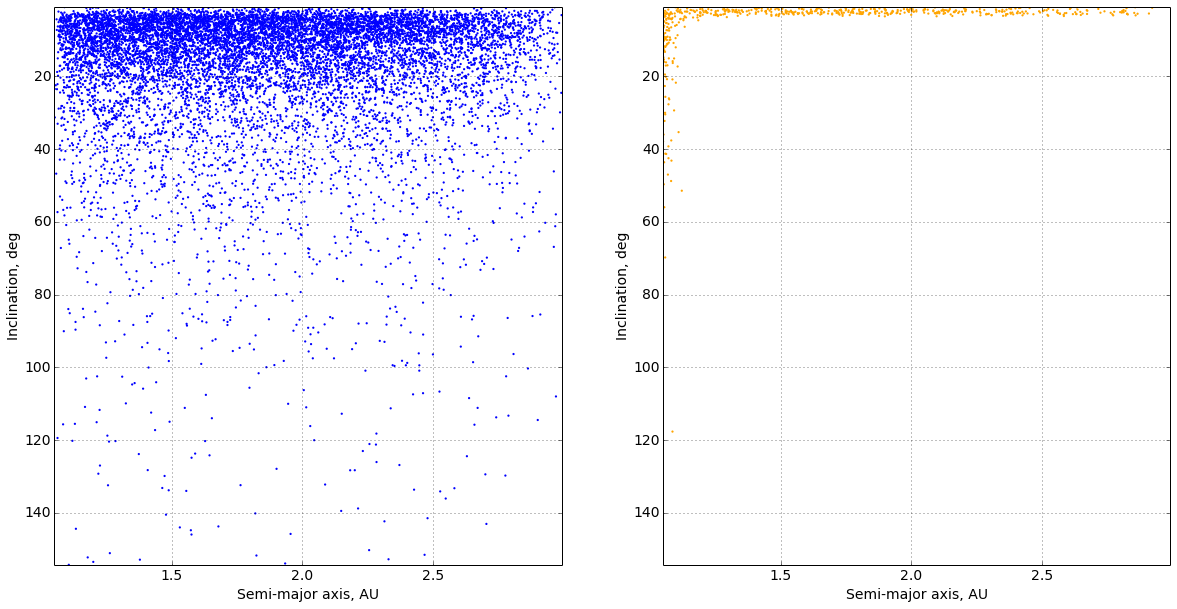

In [73]:
cutcol = ['a', 'i']
# vd.display_param2d(cutcol, labels, [haz_gen_sg1c, nohaz_gen_sg1c], invertaxes=[0,1]) #invertaxes=[0,1]
vd.display_param2d(cutcol, labels, [haz_gen_mg11, nohaz_gen_mg11], invertaxes=[0,1]) #invertaxes=[0,1]

** Apply simple cut **

In [74]:
# float(len(haz_gen_mg11))/(len(nohaz_gen_mg11) + len(haz_gen_mg11))

In [75]:
cutcol = ['a', 'i']
xtrain_mg11, ytrain_mg11 = ld.learning_sets(haz_gen_mg11, nohaz_gen_mg11, cutcol)
clf11 = tree.DecisionTreeClassifier(max_depth=2) 
clf11 = clf11.fit(xtrain_mg11, ytrain_mg11)

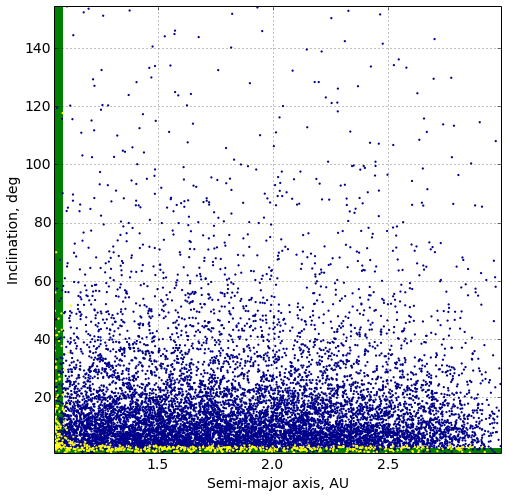

In [76]:
haz_gen_mg11_cut, nohaz_gen_mg11_cut = ld.cut_2params(cutcol, [haz_gen_mg11, nohaz_gen_mg11])
labels = [vd.colnames['a'], vd.colnames['i']]
vd.plot_classifier(xtrain_mg11, clf11, haz=haz_gen_mg11_cut, nohaz=nohaz_gen_mg11_cut, cmap='ocean_r', 
                   labels=labels, invertaxes=[0,0], rescale=False, figsize=(8,8))

** Analyse prediction score **

In [77]:
al.fit_predict(xtrain_mg11, ytrain_mg11, xtrain_mg11, ytrain_mg11, clf11)

score: 0.958427356362
predict_haz_fraction: 0.0294219753515
true_haz_fraction: 0.048602673147


** Analyse split quality for minigroup 1.1**

In [78]:
extract11 = split_minigroup(haz_gen_mg11, nohaz_gen_mg11, clf11, cutcol)
haz_gen_mg11_extr, nohaz_gen_mg11_extr, haz_gen_mg11_rest, nohaz_gen_mg11_rest = extract11

purity: 0.619469026549


In [79]:
float(len(haz_gen_mg11_extr))/(len(nohaz_gen_mg11_extr) + len(haz_gen_mg11_extr))

0.6194690265486725

## Mine minigroup 1.2

In [80]:
# vd.display_allparams([haz_gen_mg12, nohaz_gen_mg12], vd.combs, vd.colnames)

In [81]:
# haz_gen_mg12, nohaz_gen_mg12 = haz_gen_sg1c_extr, nohaz_gen_sg1c_extr

In [82]:
# cutcol = ['a', 'i']
# vd.display_param2d(cutcol, labels, [haz_gen_sg1c_extr, nohaz_gen_sg1c_extr], invertaxes=[0,1]) #invertaxes=[0,1]
# vd.display_param2d(cutcol, labels, [haz_gen_mg13, nohaz_gen_mg13], invertaxes=[0,1]) #invertaxes=[0,1]

** Apply simple cut **

In [83]:
cutcol = ['a', 'i']
xtrain_mg12, ytrain_mg12 = ld.learning_sets(haz_gen_mg12, nohaz_gen_mg12, cutcol)
clf12 = tree.DecisionTreeClassifier(max_depth=2) 
clf12 = clf12.fit(xtrain_mg12, ytrain_mg12)

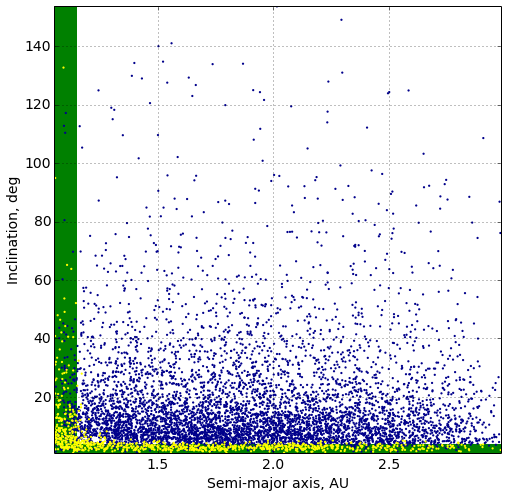

In [84]:
haz_gen_mg12_cut, nohaz_gen_mg12_cut = ld.cut_2params(cutcol, [haz_gen_mg12, nohaz_gen_mg12])
labels = [vd.colnames['a'], vd.colnames['i']]
vd.plot_classifier(xtrain_mg12, clf12, haz=haz_gen_mg12_cut, nohaz=nohaz_gen_mg12_cut, cmap='ocean_r', 
                   labels=labels, invertaxes=[0,0], rescale=False, figsize=(8,8))

**Analyse prediction score**

In [85]:
al.fit_predict(xtrain_mg12, ytrain_mg12, xtrain_mg12, ytrain_mg12, clf12)

score: 0.930545293335
predict_haz_fraction: 0.162849120733
true_haz_fraction: 0.1380227575


** Analyze split quality for minigroup 1.2**

In [86]:
extract12 = split_minigroup(haz_gen_mg12, nohaz_gen_mg12, clf12, cutcol)
haz_gen_mg12_extr, nohaz_gen_mg12_extr, haz_gen_mg12_rest, nohaz_gen_mg12_rest = extract12

purity: 0.710526315789


## Mine minigroup 1.3

In [87]:
# vd.display_allparams([haz_gen_mg13, nohaz_gen_mg13], vd.combs, vd.colnames)

** Apply simple cut **

In [88]:
cutcol = ['a', 'i']
xtrain_mg13, ytrain_mg13 = ld.learning_sets(haz_gen_mg13, nohaz_gen_mg13, cutcol)
clf13 = tree.DecisionTreeClassifier(max_depth=2) 
clf13 = clf13.fit(xtrain_mg13, ytrain_mg13)

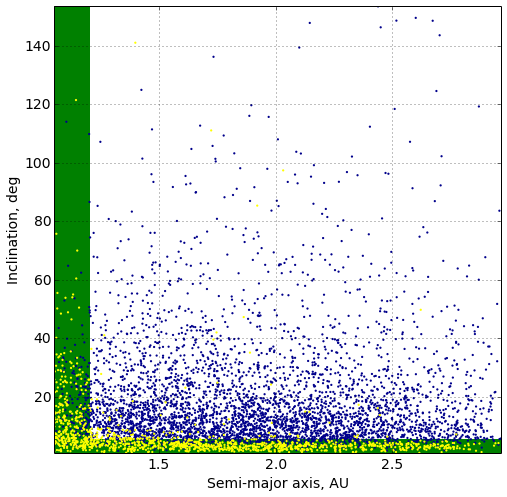

In [89]:
haz_gen_mg13_cut, nohaz_gen_mg13_cut = ld.cut_2params(cutcol, [haz_gen_mg13, nohaz_gen_mg13])
labels = [vd.colnames['a'], vd.colnames['i']]
vd.plot_classifier(xtrain_mg13, clf13, haz=haz_gen_mg13_cut, nohaz=nohaz_gen_mg13_cut, cmap='ocean_r', 
                   labels=labels, invertaxes=[0,0], rescale=False, figsize=(8,8))

**Analyse prediction score**

In [90]:
al.fit_predict(xtrain_mg13, ytrain_mg13, xtrain_mg13, ytrain_mg13, clf13)

score: 0.90052545751
predict_haz_fraction: 0.237905417648
true_haz_fraction: 0.228664613155


** Analyze split quality for minigroup 1.3**

In [91]:
extract13 = split_minigroup(haz_gen_mg13, nohaz_gen_mg13, clf13, cutcol)
haz_gen_mg13_extr, nohaz_gen_mg13_extr, haz_gen_mg13_rest, nohaz_gen_mg13_rest = extract13

purity: 0.7715156131


## Mine minigroup 1.4

In [92]:
cutcol = ['a', 'i']
xtrain_mg14, ytrain_mg14 = ld.learning_sets(haz_gen_mg14, nohaz_gen_mg14, cutcol)
clf14 = tree.DecisionTreeClassifier(max_depth=2) 
clf14 = clf14.fit(xtrain_mg14, ytrain_mg14)

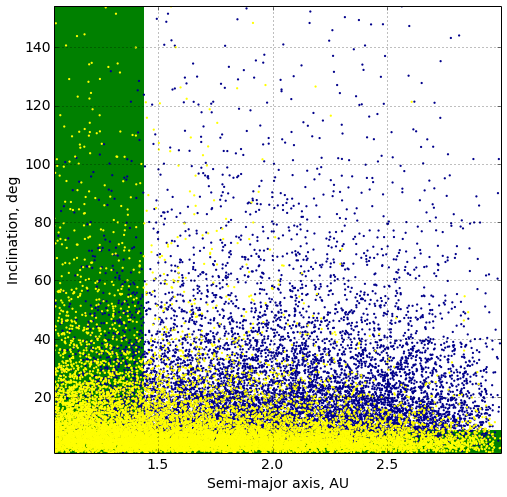

In [93]:
haz_gen_mg14_cut, nohaz_gen_mg14_cut = ld.cut_2params(cutcol, [haz_gen_mg14, nohaz_gen_mg14])
labels = [vd.colnames['a'], vd.colnames['i']]
vd.plot_classifier(xtrain_mg14, clf14, haz=haz_gen_mg14_cut, nohaz=nohaz_gen_mg14_cut, cmap='ocean_r', 
                   labels=labels, invertaxes=[0,0], rescale=False, figsize=(8,8))

In [94]:
al.fit_predict(xtrain_mg14, ytrain_mg14, xtrain_mg14, ytrain_mg14, clf14)

score: 0.78909452242
predict_haz_fraction: 0.53322568625
true_haz_fraction: 0.562124787811


In [95]:
extract14 = split_minigroup(haz_gen_mg14, nohaz_gen_mg14, clf14, cutcol)
haz_gen_mg14_extr, nohaz_gen_mg14_extr, haz_gen_mg14_rest, nohaz_gen_mg14_rest = extract14

purity: 0.829334575666


In [51]:
# vd.display_allparams([haz_genu_sg1d, nohaz_genu_sg1d], vd.combs, vd.colnames)

## Export minigroups

In [373]:
haz_mg_db = [haz_gen_mg11, haz_gen_mg12, haz_gen_mg13]
nohaz_mg_db = [nohaz_gen_mg11, nohaz_gen_mg12, nohaz_gen_mg13]

haz_mg_extr_db = [haz_gen_mg11_extr, haz_gen_mg12_extr, haz_gen_mg13_extr]
nohaz_mg_extr_db = [nohaz_gen_mg11_extr, nohaz_gen_mg12_extr, nohaz_gen_mg13_extr]

haz_mg_rest_db = [haz_gen_mg11_rest, haz_gen_mg12_rest, haz_gen_mg13_rest]
nohaz_mg_rest_db = [nohaz_gen_mg11_rest, nohaz_gen_mg12_rest, nohaz_gen_mg13_rest]

In [46]:
def dump_minigroups(haz_dbs, nohaz_dbs, prefix):
    dirpath = './asteroid_data/'
    basenames = ['gen_mg11', 'gen_mg12', 'gen_mg13']
    for haz, nohaz, basename in zip(haz_dbs, nohaz_dbs, basenames):
        hazpath = dirpath + 'haz_' + basename + prefix + '.p'
        nohazpath = dirpath + 'nohaz_' + basename + prefix + '.p'
        rdb.dumpObject(haz, hazpath)
        rdb.dumpObject(nohaz, nohazpath)

In [47]:
prefixes = ['', '_extr', '_rest']
haz_dbs = [haz_mg_db, haz_mg_extr_db, haz_mg_rest_db]
nohaz_dbs = [nohaz_mg_db, nohaz_mg_extr_db, nohaz_mg_rest_db]

dumpall = [dump_minigroups(haz, nohaz, prefix) 
           for haz, nohaz, prefix in zip(haz_dbs, nohaz_dbs, prefixes)]

## Plot desision boundaries for minigroups in a-i space

In [51]:
# reload(vd)
# labels = [vd.colnames['a'], vd.colnames['i']]
# vd.plot_onegroup(xtrain_mg11, clf11, -4, [-4.0, 0.0], labels=labels, figsize=(8,8))

In [52]:
# vd.plot_onegroup(xtrain_mg12, clf12, -3, [-4.0, 0.0], labels, figsize=(8,8))

In [53]:
# vd.plot_onegroup(xtrain_mg13, clf13, -2, [-4.0, 0.0], labels=labels, figsize=(8,8))